In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
# Inline so we can draw it in Jupyter
%matplotlib inline

This function makes sure that the dataframe length is the same in any case, no matter if there are no values for certain indexes.

In [2]:
def check_for_missing_index_values(df):
    index_list = [1,2,3,4,5,6,7,10]
    for idx in index_list:
        try:
            temp = df.loc[idx][0]
        except:
            df.loc[idx] = [0]

    df = df.sort_index()
    return df

This function splits our check-in date to different values so we get a column for each value

In [3]:
def split_checkin_to_date_columns(df):
    
    day_date_array = [] 
    month_array = [] 
    year_array = [] 
    day_in_a_week_array = []
    week_days_js = {
            0 : 2,
            1 : 3,
            2 : 4,
            3 : 5,
            4 : 6, 
            5 : 7, 
            6 : 1,
    }
    
    # Create and return the arrays so we can use them to create columns
    for part in df:
        date = datetime.datetime.strptime(part ,'%Y-%m-%d').date()
        day = date.day
        month = date.month
        year = date.year     
        day_in_week = week_days_js[datetime.date(day=day, month=month, year=year).weekday()]
        day_date_array.append(day)
        month_array.append(month)
        year_array.append(year)
        day_in_a_week_array.append(day_in_week)    
        
    return day_in_a_week_array,day_date_array,month_array,year_array


Add to our dataframe the values we got from the above function 

In [4]:
def add_new_columns_dates(df,day_in_a_week_array,day_date_array,month_array,year_array):
    df.insert(loc=1, column='day', value=day_in_a_week_array)
    df.insert(loc=2, column='date_day', value=day_date_array)
    df.insert(loc=3, column='month', value=month_array)
    df.insert(loc=4, column='year', value=year_array)
    
    return df2

Add our dates as columns so we can use them for the Machine Learning

In [5]:
def add_date_columns(df2):
    dates_columns = df2['check_in']
    day_in_a_week_array,day_date_array,month_array,year_array = split_checkin_to_date_columns(dates_columns)
    df2 = add_new_columns_dates(df2,day_in_a_week_array,day_date_array,month_array,year_array)
    return df2

Create a dataframe for creating the graph for the given month, year

In [6]:
def create_dataframe_for_graph(df,df_result,year,month,first_time_run):
    
    # Month less than 10 so we know if to add 0 or not before the month
    if month < 10:
        df_by_month = df[df['check_in'].dt.strftime('%Y-%m') == str(year)+'-0'+str(month)]
    else:
        df_by_month = df[df['check_in'].dt.strftime('%Y-%m') == str(year)+'-'+str(month)]
    
    #
    df_groupby_available_rooms = df_by_month['available_rooms'].value_counts()
    how_many_available_rooms = sorted(df_groupby_available_rooms.keys().tolist())
    df_final = pd.DataFrame(df_groupby_available_rooms,index=how_many_available_rooms)
    
    # If we run the function for the first time we create the df_temp
    if(first_time_run):        
        df_temp = pd.DataFrame(index=how_many_available_rooms)
        ## https://www.geeksforgeeks.org/python-pandas-dataframe-assign/ ## 
        df_temp = df_temp.assign(month_name=df_final.values)
        df_temp = check_for_missing_index_values(df_temp)
        df_temp.rename(columns = {'month_name':str(month)+"."+str(year)[int(len(str(year))/2):]}, inplace = True)
        df_result = df_temp      
    else:
        try:
            df_final = check_for_missing_index_values(df_final)
            df_result = df_result.assign(month_name=df_final.values)
        except:
            pdb.set_trace()  
        #    
        df_result = check_for_missing_index_values(df_result)
        df_result.rename(columns = {'month_name':str(month)+"."+str(year)[int(len(str(year))/2):]}, inplace = True) 
        
    return df_result
    

Here we get graphs for each parameter type to show its relation in each month for the number of available rooms in the hotels.

In [7]:
def get_graph_for_available_room_by_paramater(df2,first_month,year,parm,parameter_type):
    # first_month is the month we start our crawling with
    i = first_month
    # Month is 13 as 365 days can sometimes mean 13 months switched if we start close to the end of the month
    month = 13 
    df_result = pd.DataFrame()
    first_time_run = True
    
    # Create graphs while we didn't pass the last month we need
    while(month != 0):
        # Create a dataframe for the graph, for our current month and year
        df_result = create_dataframe_for_graph(df2,df_result,year,i,first_time_run)
        first_time_run = False
        # When i == 12 we need to switch to the next year
        if( i == 12 ):
            i = 1 
            year = str(int(year)+1)
        else:
            i = i + 1

        month= month - 1
    
    # Transpose the df 
    df_result = df_result.T
    
    # 2 parts - 1 is from the first month to the sixth, part 2 is from the sixth to the last month.
    df_result_part1 = df_result.drop(df_result.index[6:13])
    df_result_part2 = df_result.drop(df_result.index[0:6])
    
    ## https://datatofish.com/bar-chart-python-matplotlib/  - creating 2 line plots side by side.
    df_result_part1.plot(kind='bar')
    plt.ylabel('Available Rooms by '+ '\n'+str(parm)+ '\n'+parameter_type)
    plt.xlabel('Month and Year')
    
    df_result_part2.plot(kind='bar')
    plt.ylabel('Available Rooms by '+ '\n'+ str(parm)+ '\n'+parameter_type)
    plt.xlabel('Month and Year')
  
    plt.show()

    return 


This function will get us a graph according to the given parameter type given to it.

In [8]:
def get_graph_by_paramter(df2,parameter,parameter_list,parameter_type):
    
    # Here we get the first month and first year of our dataframe.
    df2['check_in'] = pd.to_datetime(df2['check_in'])  
    first_month = df2['check_in'][0].month
    year = df2['check_in'][0].year
    
    # In these if's, print all of the graphs for each range in every parameter type.
    if (parameter_type == "Star" ) :
        for parm in parameter_list:
            df_by_param = df2[df2[parameter] == parm]
            df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
            get_graph_for_available_room_by_paramater(df_by_param,first_month,year,parm,parameter_type)
    
    
    if (parameter_type == "Distance From Center" ) :
        ### distance_from_center < 0.5 ##
        parm = parameter_list[0]
        df_by_param = df2[parameter_list[0] > df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm)+">",parameter_type)
        
        ##    0.5 < distance_from_center < 1 ##
        parm = "0.5 < distance < 1 "
        df_by_param = df2[  (parameter_list[0] < df2[parameter]) &  ( parameter_list[1] > df2[parameter])]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
    
        ## distance_from_center > 1 ##    
        parm = "distance > 1 "
        df_by_param = df2[parameter_list[1] < df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
            
            
    if (parameter_type == "Hotel Rating" ) :

       ### Hotel Rating < 8 ##
        parm = parameter_list[0]
        df_by_param = df2[parameter_list[0] > df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm)+">",parameter_type)
        
        ##    8 < Hotel Rating < 9 ##
        parm = "8 < rating < 9 "
        df_by_param = df2[  (parameter_list[0] < df2[parameter]) &  ( parameter_list[1] > df2[parameter])]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
    
    
        ## Hotel Rating > 9 ##         
        parm = "rating > 9 "
        df_by_param = df2[parameter_list[1] < df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
                    
    if (parameter_type == "Hotel Price"):
       ### Hotel Price < 300 ##
        parm = parameter_list[0]
        df_by_param = df2[parameter_list[0] > df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm)+">",parameter_type)
        
        ##    300 < Price < 600 ##
        parm = "300 < Price < 600 "
        df_by_param = df2[  (parameter_list[0] < df2[parameter]) &  ( parameter_list[1] > df2[parameter])]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
    
        ## 600 < Price < 1000  ## 
        parm = "600 < Price < 1000 "
        df_by_param = df2[  (parameter_list[1] < df2[parameter]) &  ( parameter_list[2] > df2[parameter])]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
        
         ## 1000 < Price < 2000 ## 
        parm = "1000 < Price < 2000 "
        df_by_param = df2[  (parameter_list[2] < df2[parameter]) &  ( parameter_list[3] > df2[parameter])]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
    
        
        ## Price > 2000 ##
        parm = "Price > 2000 "
        df_by_param = df2[parameter_list[3] < df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
        
    return 

These functions print the graph for each parameter using our get_graph_by_paramter function.

In [9]:
def get_graph_for_stars_count(df):
    parameter = 'stars_count'
    parameter_list = [0,3,4,5]
    parameter_type = "Star"
    get_graph_by_paramter(df,parameter,parameter_list,parameter_type)
    return

def get_graph_for_distance_from_center(df):
    parameter = "distance_from_center"
    parameter_list = [0.5,1] 
    parameter_type = "Distance From Center"
    get_graph_by_paramter(df,parameter,parameter_list,parameter_type)
    return

def get_graph_for_hotel_rating(df):
    parameter = "hotel_rating"
    parameter_list = [8,9] 
    parameter_type = "Hotel Rating"
    get_graph_by_paramter(df,parameter,parameter_list,parameter_type)
    return

def get_graph_for_hotel_price(df):
    parameter = "hotel_price"
    parameter_list = [300,600,1000,2000] 
    parameter_type = "Hotel Price"
    get_graph_by_paramter(df,parameter,parameter_list,parameter_type)
    return


Get the mean of our average price for all of the hotels for the whole month, or just one hotel.


In [10]:
def get_avg_price(df, hotel_name):
    if hotel_name == "all":
        df2 = df.groupby("month")["hotel_price"].mean()
    else:
        df2= df[df['hotel_name'] == hotel_name].groupby("month")["hotel_price"].mean()
    
    return df2

Get the mean of the average avilable rooms for the whole month, or just one hotel.

In [11]:
def get_avg_available_rooms(df, hotel_name):
    if hotel_name == "all":
        
        df2 = df.groupby("month")["available_rooms"].mean()
    else:
        df2= df[df['hotel_name'] == hotel_name].groupby("month")["available_rooms"].mean()
     
    return df2

Get the 2 graphs of average price and average avilable rooms in relation for each month of the year.

In [12]:
def get_avg_price_vs_available_room_graph_by_month(df):
    # 
    month_list = []
    avg_price_df = get_avg_price(df,'all')
    avg_avaialble_room_df=  get_avg_available_rooms(df,'all')
    
    # Get all of the months we need according to the month we started with.
    first_month = datetime.datetime.now().month
    for i in range(0,12):     
        if (first_month == 13):
            first_month = 1
            month_list.append(first_month)
            first_month= first_month+1
        else:
            month_list.append(first_month)
            first_month= first_month + 1
            
    # Now create a dataframe with our needed months list, and the means of the price and available rooms per month,
    # So we can create 2 graphs for them to see what we can understand about them for every month of the year.
    result = pd.DataFrame({ 'month' : month_list,
                             'avg_price': avg_price_df.values,
                            'avg_avaialble_room': avg_avaialble_room_df.values})
    
    # https://www.tutorialspoint.com/how-to-make-two-plots-side-by-side-using-python 
    plt.subplot(1, 3, 1) # row 1, col 2 index 1
    plt.plot(avg_price_df.index.values, avg_price_df.values)
    plt.title("Month VS AVG PRICE")
    plt.xlabel('Month')
    plt.ylabel('AVG PRICE')

    plt.subplot(1, 2, 2) # index 2
    plt.plot(avg_price_df.index.values, avg_avaialble_room_df.values)
    plt.title("Month VS AVG AR")
    plt.xlabel('MONTH')
    plt.ylabel('AR')

    return 


We checked that our dataframe is all correct and has no duplicates nor nulls, and we see that all of its information seems ok.
From our graphs we can understand that the available rooms number is lower on the warmer months in Eilat, especially in July-August, afterwards the kids go back to school.. We also added as a bonus the other graphs to see that the average prices are going up as well in those warmer months and more graphs that show the available rooms according to many of the other properties that hotels have on booking.

----------Graph Info---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9314 entries, 0 to 9313
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   check_in              9314 non-null   object 
 1   hotel_name            9314 non-null   object 
 2   available_rooms       9314 non-null   int64  
 3   hotel_price           9314 non-null   int64  
 4   hotel_rating          9314 non-null   float64
 5   preferred_hotel       9314 non-null   int64  
 6   number_of_reviews     9314 non-null   int64  
 7   distance_from_center  9314 non-null   float64
 8   stars_count           9314 non-null   int64  
 9   new_hotel             9314 non-null   int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 727.8+ KB
None


----------Null Cells Check---------
check_in                0
hotel_name              0
available_rooms         0
hotel_price             0
hotel_rating            0
preferred_hote

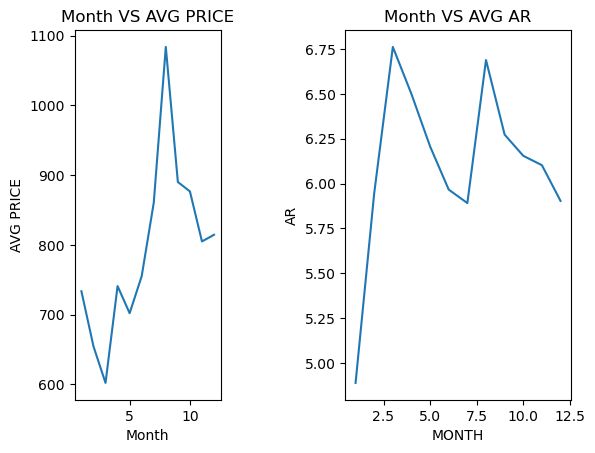

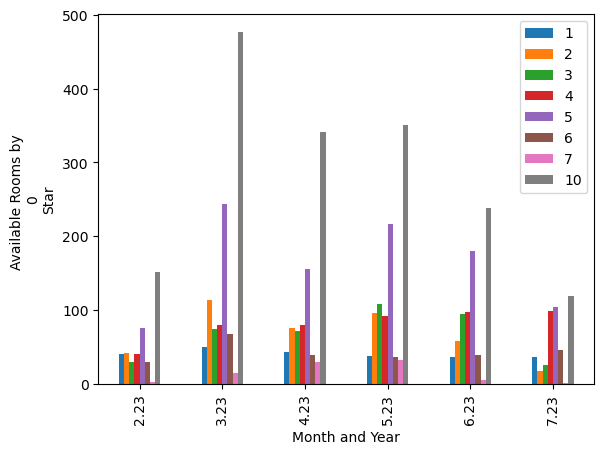

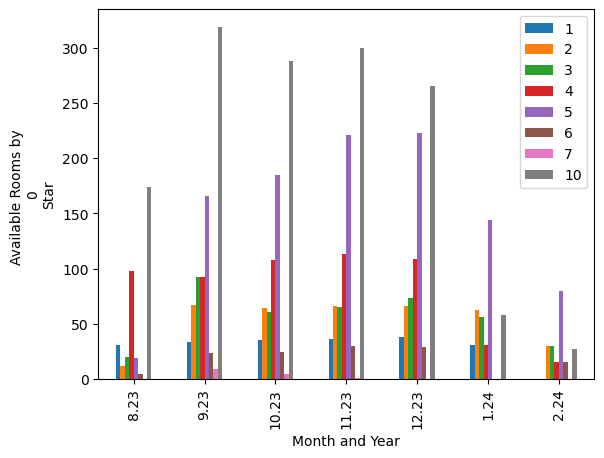

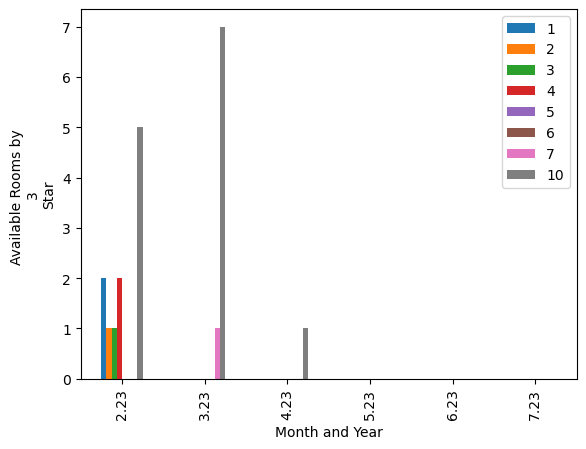

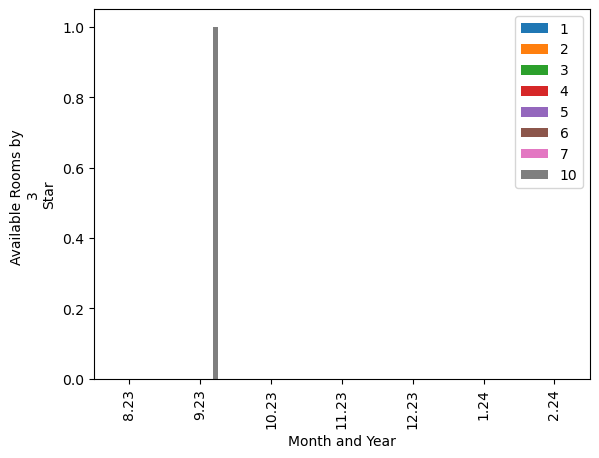

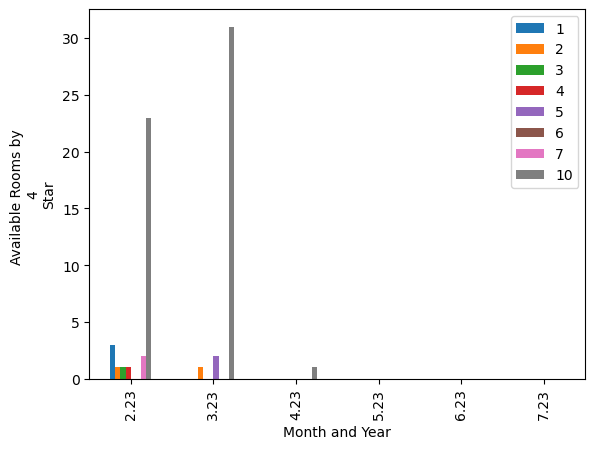

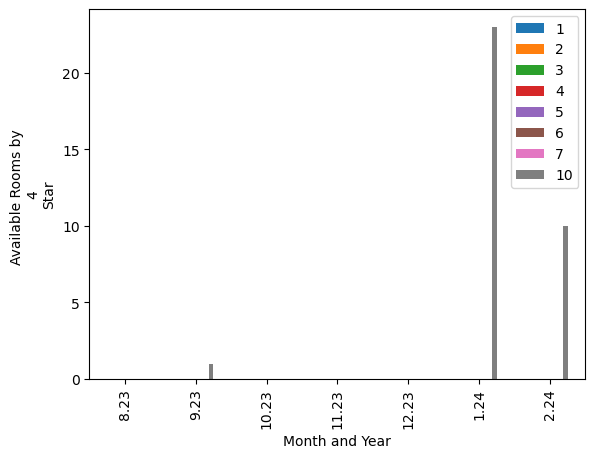

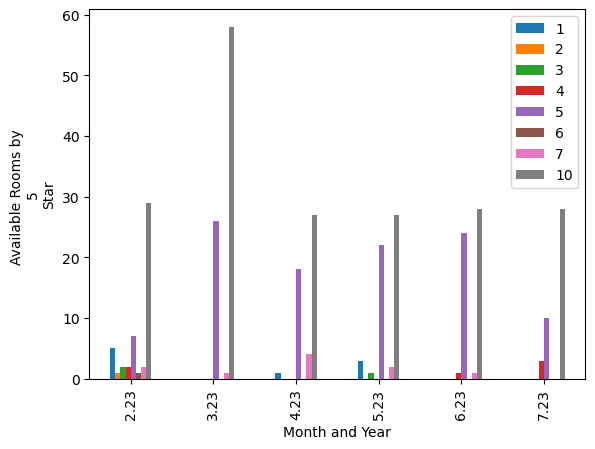

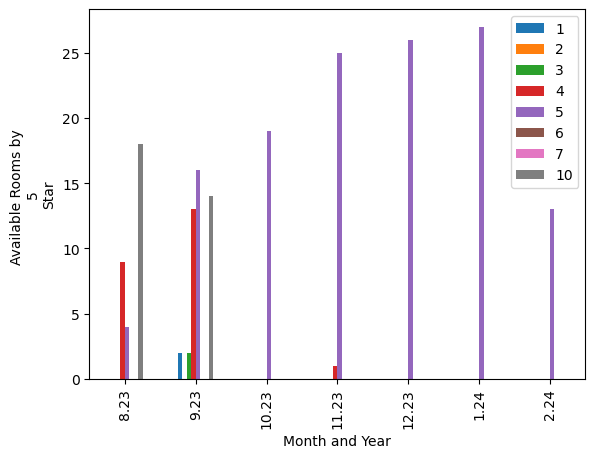

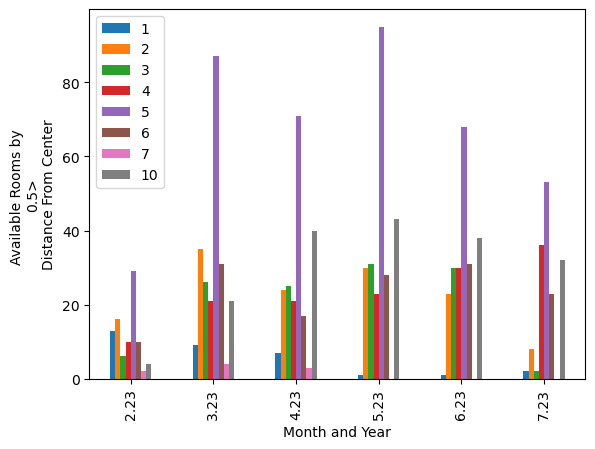

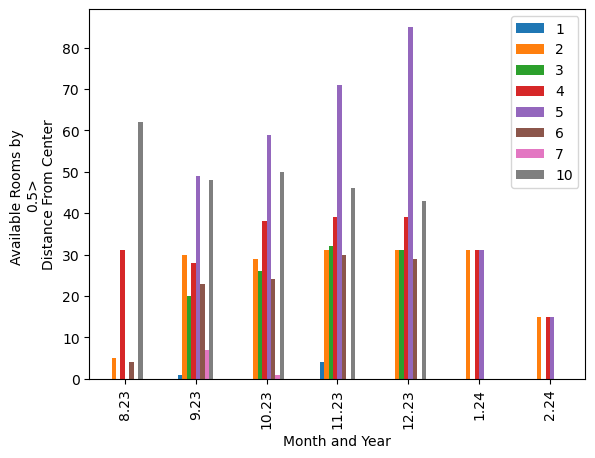

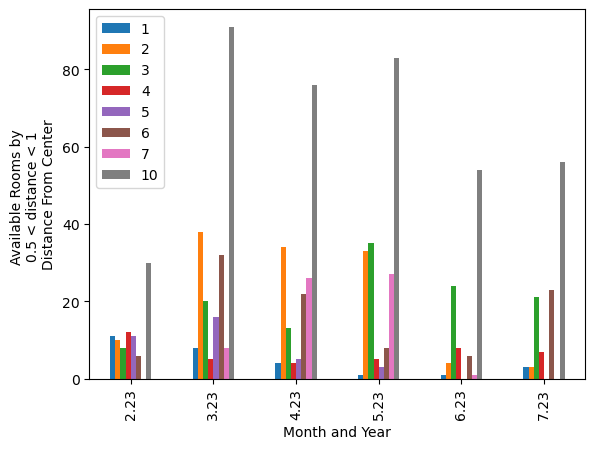

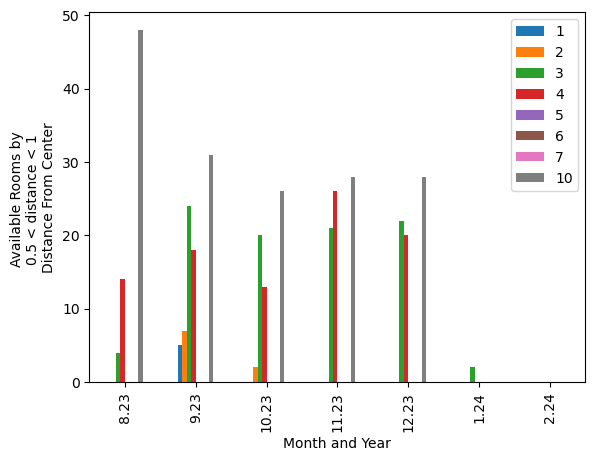

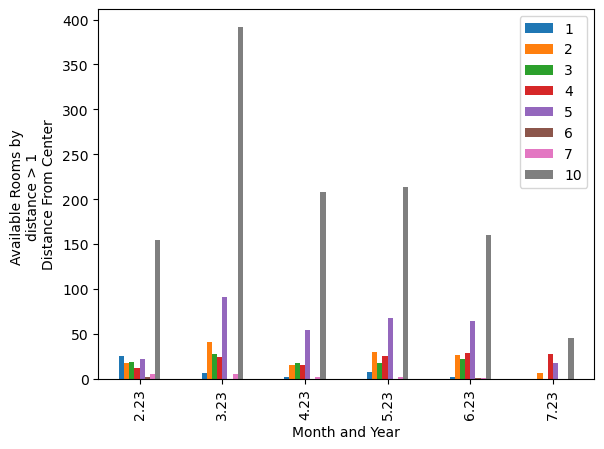

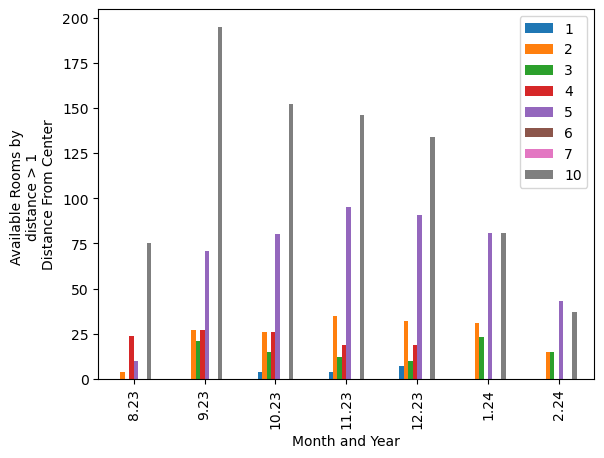

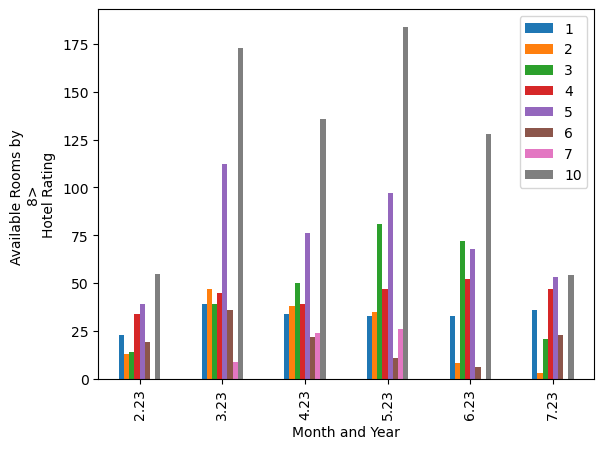

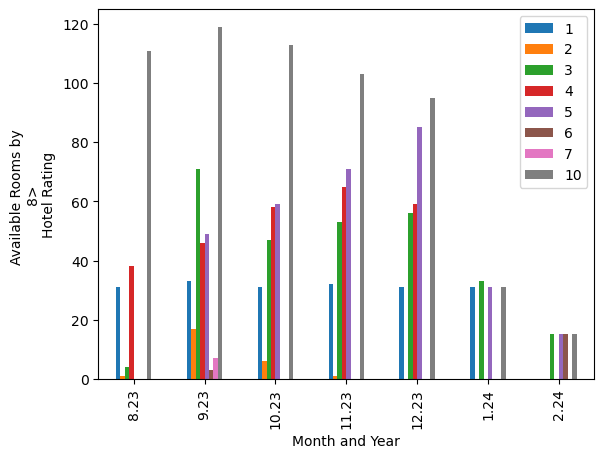

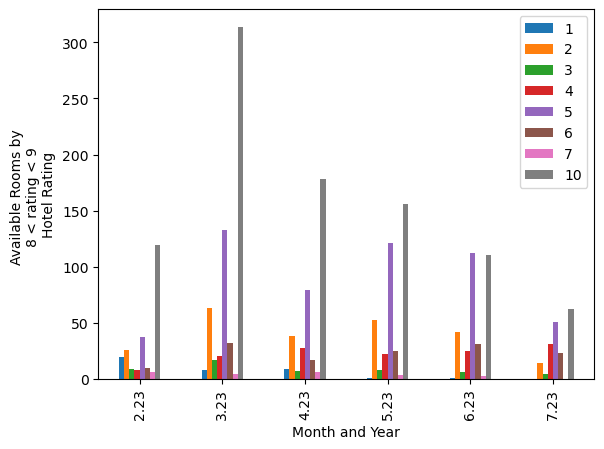

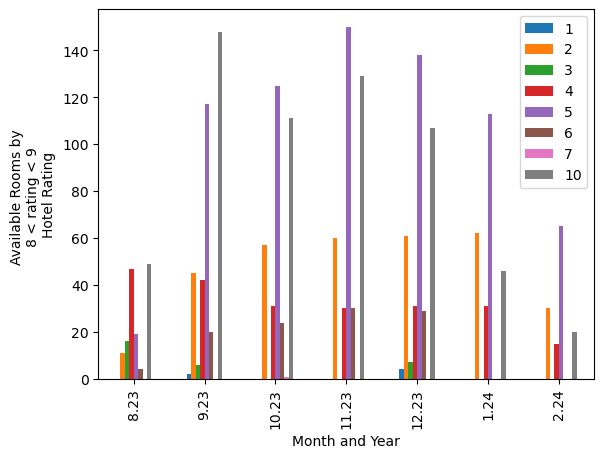

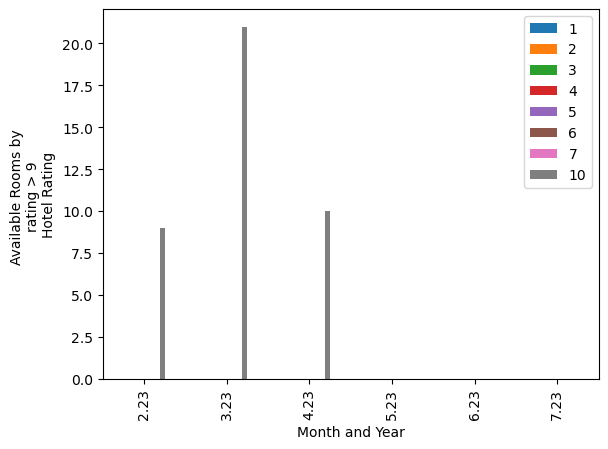

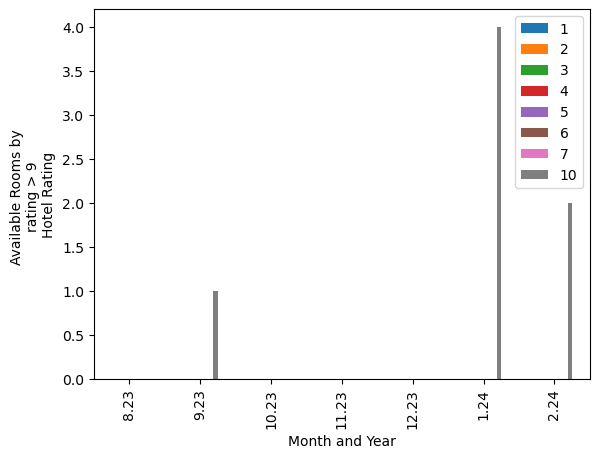

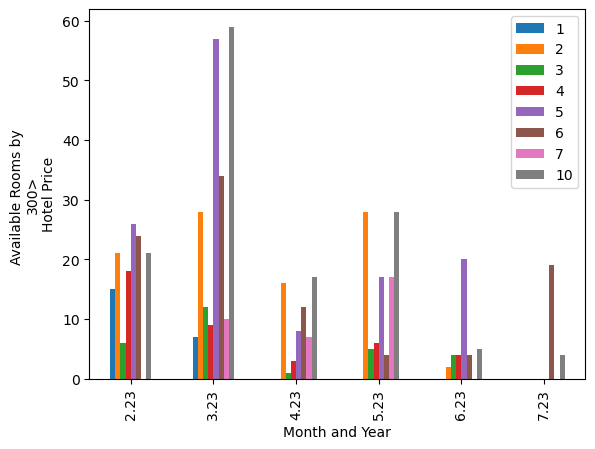

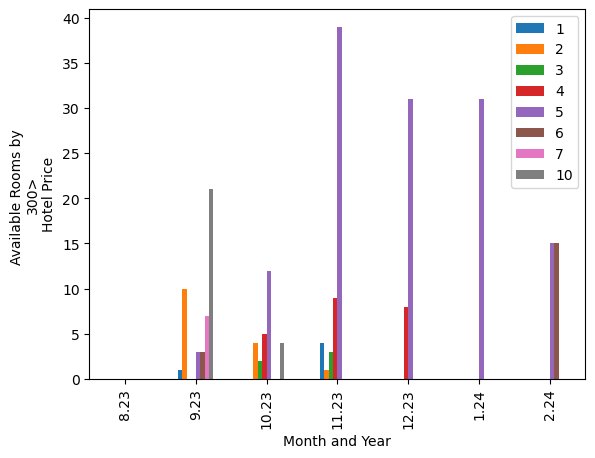

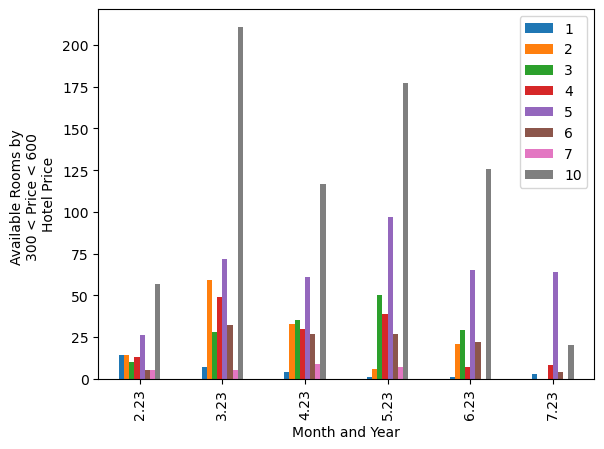

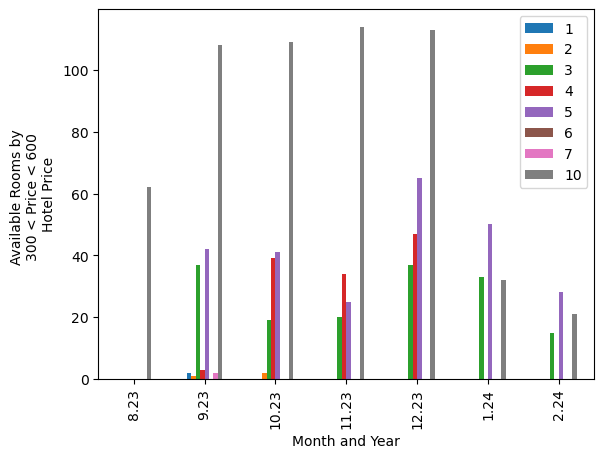

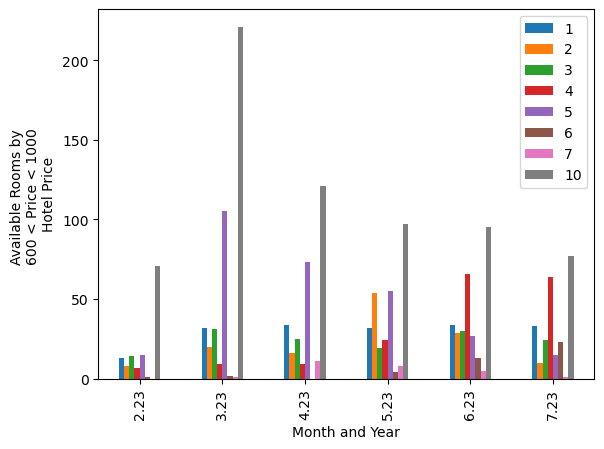

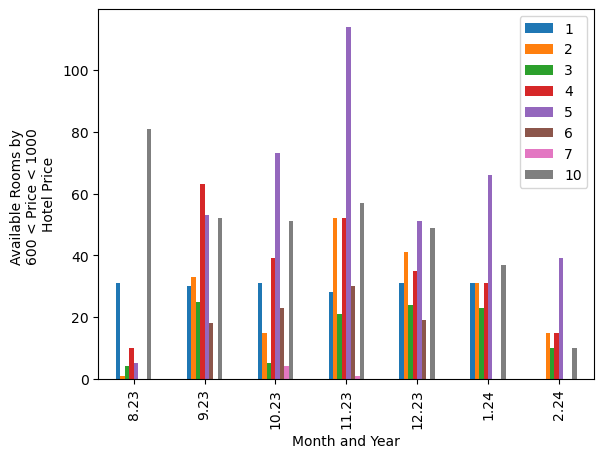

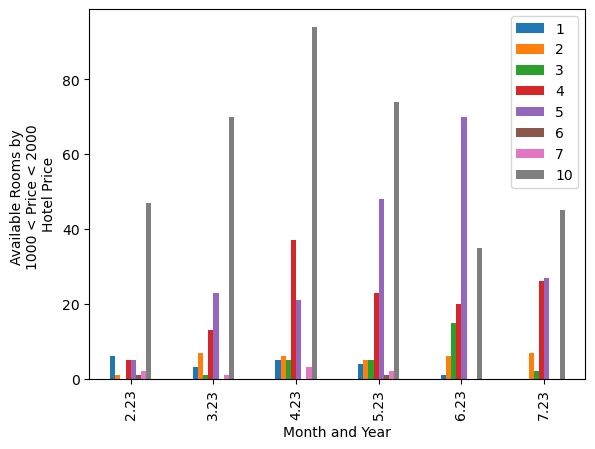

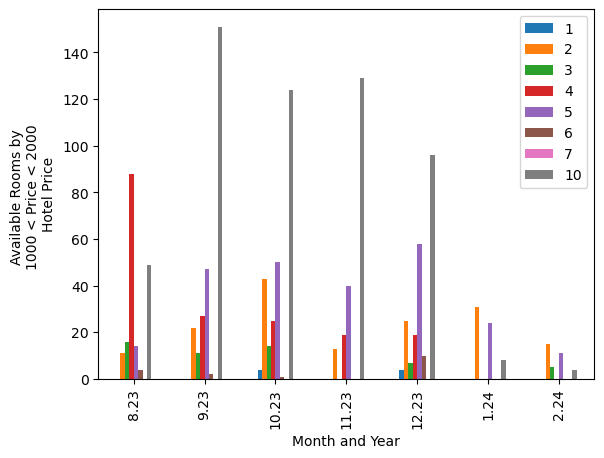

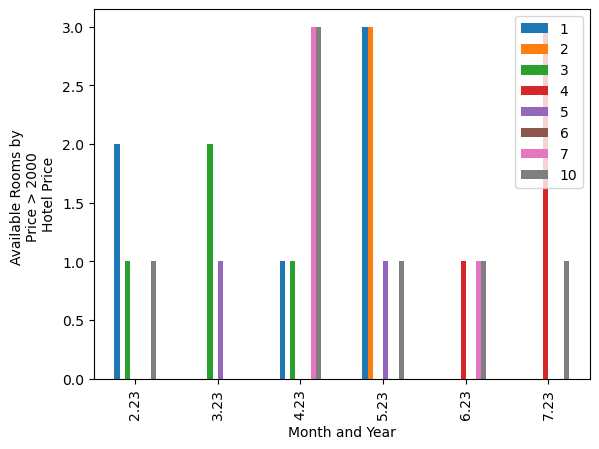

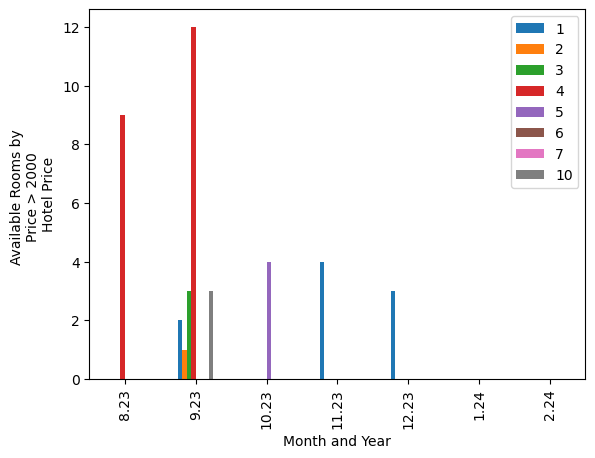

In [13]:
# Our main code - we read our 365 days csv, filter the data we 
# don't need (edge cases like very low hotel ratings or unavailable hotels)
# and then check that the dataframe is ok for starting the EDA.
if __name__ == "__main__":
    df = pd.read_csv('./CsvFolder/Hotels365Day.csv')
    df2 = df.iloc[:, 1:].reset_index(drop=True)
    df2.drop(df2[df2['hotel_rating'] < 3].index, inplace = True)
    df2.drop(df2[df2['number_of_reviews'] < 10].index, inplace = True)
    df2.drop(df2[df2['hotel_price'] < 0].index, inplace = True) # If hotel not available at that date, remove it.
    print("----------Graph Info---------")
    print(df2.info())
    print('\n')
    print("----------Null Cells Check---------")
    print(df2.isna().sum())
    print('\n')
    print("----------Duplicated Check---------")
    print("There are "+str(df.duplicated().sum())+" duplicated rows")
    print('\n')
    # Add the dates' values as columns to our dataframe for the machine learning (day in the week, day, month, year)
    df2 = add_date_columns(df2)
    # Get the 2 graphs of average price and average avilable rooms in relation for each month of the year.
    get_avg_price_vs_available_room_graph_by_month(df2)

    get_graph_for_stars_count(df2)
    get_graph_for_distance_from_center(df2)
    get_graph_for_hotel_rating(df2)
    get_graph_for_hotel_price(df2)    